# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

## WARNING

The analysis below shows that GEOS precomputes envolveop and is therefore faster...

# Prerequisites

Generate data:

```bash
cd harness
cargo build --release
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/relwithdebinfo" target/release/benchmark_mbr --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
                qps                                          
program         geo        geos  geos_twice geos_twice_cloned
count    150.000000  150.000000  150.000000        150.000000
mean       4.018715    2.780438    1.383408          1.379787
std        1.453365    1.003928    0.498581          0.492094
min        2.048825    1.271923    0.641910          0.649461
25%        2.352542    1.984034    0.990480          0.989995
50%        3.325986    1.995892    0.997271          0.994337
75%        5.703653    3.988315    1.982171          1.979353
max        5.733248    4.044225    2.016591          2.013896


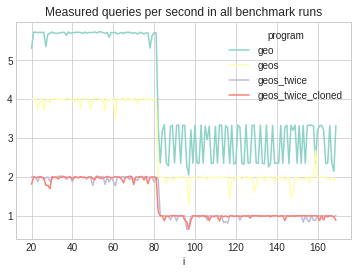

### Statistics: After outlier removal
                qps                                          
program         geo        geos  geos_twice geos_twice_cloned
count    150.000000  150.000000  150.000000        150.000000
mean       4.018715    2.780438    1.383408          1.379787
std        1.453365    1.003928    0.498581          0.492094
min        2.048825    1.271923    0.641910          0.649461
25%        2.352542    1.984034    0.990480          0.989995
50%        3.325986    1.995892    0.997271          0.994337
75%        5.703653    3.988315    1.982171          1.979353
max        5.733248    4.044225    2.016591          2.013896


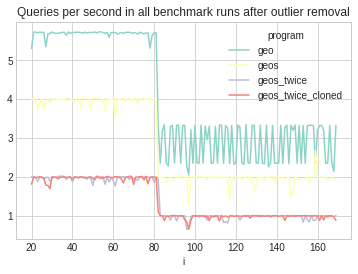

## Ratio of qps compared to geo
                qps                              
program        geos  geos_twice geos_twice_cloned
count    150.000000  150.000000        150.000000
mean       0.701941    0.349584          0.348906
std        0.103839    0.054398          0.050036
min        0.440748    0.246939          0.257813
25%        0.604094    0.301143          0.299529
50%        0.700409    0.347504          0.346994
75%        0.777115    0.401164          0.406354
max        1.140774    0.584907          0.451261


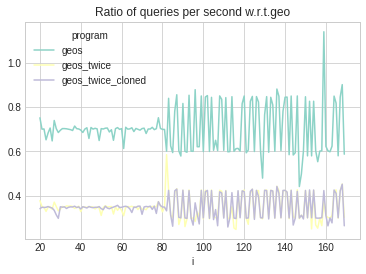

## Ratio of qps compared to geos
                qps                              
program         geo  geos_twice geos_twice_cloned
count    150.000000  150.000000        150.000000
mean       1.454971    0.500002          0.498565
std        0.211454    0.054841          0.036729
min        0.876598    0.322273          0.370467
25%        1.286911    0.493904          0.491781
50%        1.427737    0.499030          0.497828
75%        1.655371    0.503075          0.503123
max        2.268870    0.972799          0.688069


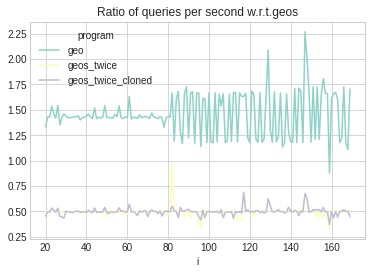

In [59]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb
data_series = series_sans_outliers

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.

## It's all just destructors

I didn't hvae geos with debugging information. Much better flamegraph once we have that:
 
![](./perf2.svg)

But somehow, geos became **slower** than geo. (should retry without debugsyms again) Verified that geos is still built with `-O2`.

Also, all the time being measured in geos is just destructors. See `./perf.hist.0`.

![](./only-distructors.png)


# gdb

Verified with gdb that:

* computeEnvelopeInternal is hit _before_ measurement, and never during measurement.
* It is hit when I compute the envelope to print it out.
  * It seems that the cached envelope is cloned with `Clone`. Kind of expected in retrospect, eh?


Next things to try:
* Tweak harness so that the variables are not dropped during measurement.
* Tweak benchmark_mbr so that it `Clone`s **before** computing envelope.
  * Verify with gdb that computeEnvelopeInternal is hit in the measurement.

![](./envelope_outside_harness.png)


# No more destructors

After ensuring that values aren't dropped while being measured:

* QPS doubled for all
* runtime ratio stayed unchanged
* callgraphs look better:
![](./NoMoreDestruction.png)


# It's all just allocations!

* On re-introducing computeEnvelopeInternal, the ratio didn't change much. So most of the time is spent in allocating geometries.
* geos spends time allocating, and the actual computation is super fast
* geo spends time computing the MBR, allocation does not show up in perf at all.
  
![](mbr-perf.png)

# Uber-optimized

When building without debug info, gcc -O3 is used. This makes geos faster.

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" target/release/benchmark_mbr --out-file ../analysis/benchmark_mbr/data-nodbg.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data-nodbg.json
### Statistics: Raw data
                qps                                          
program         geo        geos  geos_twice geos_twice_cloned
count    150.000000  150.000000  150.000000        150.000000
mean       5.318999   53.540495   26.492808         26.482662
std        1.011920   10.311720    5.177043          5.133809
min        0.982221    7.893737    5.156616          3.381448
25%        5.652018   55.962688   28.119589         28.009199
50%        5.693759   57.354055   28.344813         28.295366
75%        5.714754   57.792542   28.594010         28.484988
max        5.741387   58.144274   28.750069         28.683689


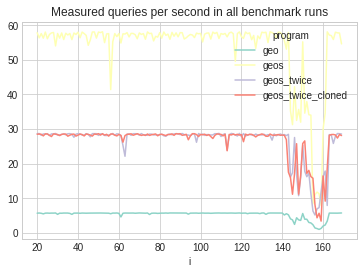

### Statistics: After outlier removal
                qps                                          
program         geo        geos  geos_twice geos_twice_cloned
count    134.000000  134.000000  134.000000        134.000000
mean       5.636177   56.572481   28.068889         28.051453
std        0.251385    3.107048    1.613841          1.454233
min        3.928543   34.596054   16.227331         17.183425
25%        5.673228   56.286722   28.206309         28.155571
50%        5.697156   57.494424   28.399837         28.359327
75%        5.717009   57.815418   28.606787         28.507635
max        5.741387   58.144274   28.750069         28.683689


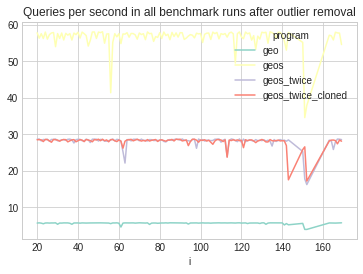

## Ratio of qps compared to geo
                qps                              
program        geos  geos_twice geos_twice_cloned
count    134.000000  134.000000        134.000000
mean      10.038879    4.980464          4.981474
std        0.405027    0.220733          0.267225
min        7.506579    3.869280          3.374195
25%        9.907107    4.950572          4.943806
50%       10.102032    5.000231          4.984060
75%       10.156330    5.019382          5.009260
max       11.966760    6.135396          6.761712


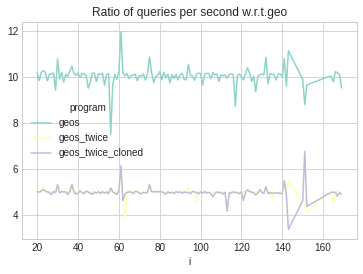

## Ratio of qps compared to geos
                qps                              
program         geo  geos_twice geos_twice_cloned
count    134.000000  134.000000        134.000000
mean       0.099787    0.496667          0.497167
std        0.004420    0.025688          0.036542
min        0.083565    0.384934          0.302656
25%        0.098461    0.490015          0.489808
50%        0.098990    0.495230          0.493608
75%        0.100938    0.504884          0.503339
max        0.133216    0.686527          0.768289


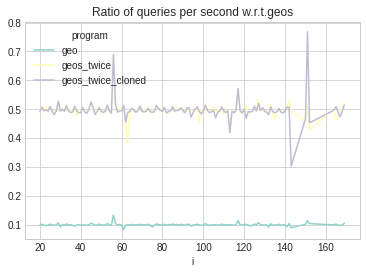

In [60]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data-nodbg.json')
%run ../common/benchmark_analysis.ipynb

# Uber optimized geos - perf analysis.

Generate with:

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" perf record -F 300 -g --call-graph dwarf -o ../analysis/benchmark_mbr/perf-nodbg.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null
```

`geos_mbr` is now faster than `geo_mbr`. But most of the time is still spent in creating the geometry (so allocation gets optimized to the point that it's faster...)

Snippet from

```bash
perf report -i perf-nodbg.data --call-graph=fractal,0.5
```

![](./fast-geos-mbr-still-alloc.png)

# Root Cause

Costliest step, in *both cases* are the intermediate geometries that are generated for MBR.

For geos:

![](./envelope-repeat-wrap.png)

For geo, the code looks similar, but looking at the (inlined) assembly, the `Rect::new` statement
is reduced to just some [double precision move operations](https://c9x.me/x86/html/file_module_x86_id_204.html)

![](./rect_new_asm.png)

Thus, Rust is able to completely optimize away the allocations that C++ finds costly!
But, under `-O3`, C++ does such a good of optimizing the allocatins that they're still the costliest, but cheaper than the min/max calculation in Rust... :/


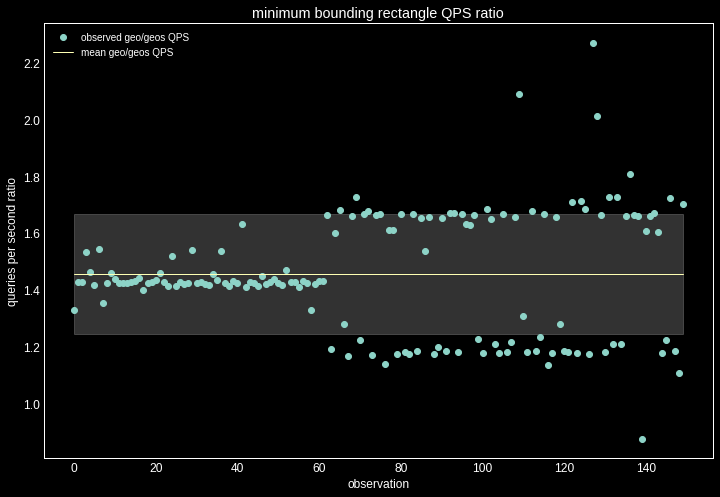

In [61]:
series_geo = data_series.iloc[:, 0]
assert series_geo.name == ('qps', 'geo')
series_geos = data_series.iloc[:, 1]
assert series_geos.name == ('qps', 'geos')

ratio = series_geo.divide(series_geos)
ratio.describe()

plt.style.use('dark_background')

@plt.rc_context({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'image.cmap': plt.get_cmap('Pastel1'),
})
def initialize_plot():
    fig = plt.figure()
    return fig.add_subplot(title='minimum bounding rectangle QPS ratio')

x = range(ratio.size)
ax = initialize_plot()
ax.plot(x, ratio, linewidth=0, marker='o', label='observed geo/geos QPS')
ax.plot(x, [ratio.mean()] * ratio.size, linewidth=1, label='mean geo/geos QPS')
ax.fill_between(x, ratio.mean() - ratio.std(), ratio.mean() + ratio.std(), alpha=0.2, color='white')
ax.legend()
ax.set_xlabel('observation')
ax.set_ylabel('queries per second ratio')
ax.grid(False)
plt.savefig('mbr_qps_ratio.svg', transparent=True)

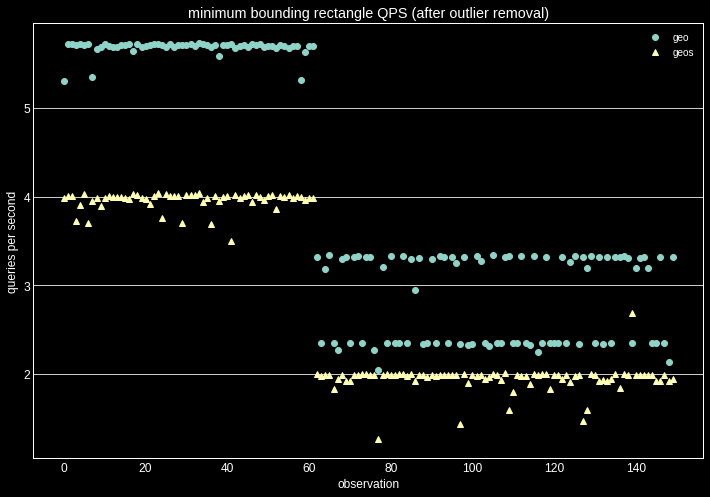

In [62]:
@plt.rc_context({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'image.cmap': plt.get_cmap('Pastel1'),
})
def initialize_plot():
    fig = plt.figure()
    return fig.add_subplot(title='minimum bounding rectangle QPS (after outlier removal)')

assert series_geo.size == series_geos.size
x = range(series_geo.size)
ax = initialize_plot()
ax.plot(x, series_geo, linewidth=0, marker='o', label='geo')
ax.plot(x, series_geos, linewidth=0, marker='^', label='geos')
ax.legend()
ax.set_xlabel('observation')
ax.set_ylabel('queries per second')
ax.xaxis.grid(False)
plt.savefig('mbr_qps.svg', transparent=True)